# Setup

In [1]:
import pandas as pd
import numpy as np
# To plot the pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

# Import Data

In [2]:
insurance = pd.read_csv("medical cost.zip")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Take a Quick Look at the Data Structure

In [3]:
# get a quick description of the data
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# find out the categories that exist in the categorical columns and their counts
for col in insurance.select_dtypes(include="object"):
    print(f"{insurance[col].value_counts()}\n")

sex
male      676
female    662
Name: count, dtype: int64

smoker
no     1064
yes     274
Name: count, dtype: int64

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64



In [5]:
# summary of the numerical attributes
insurance.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


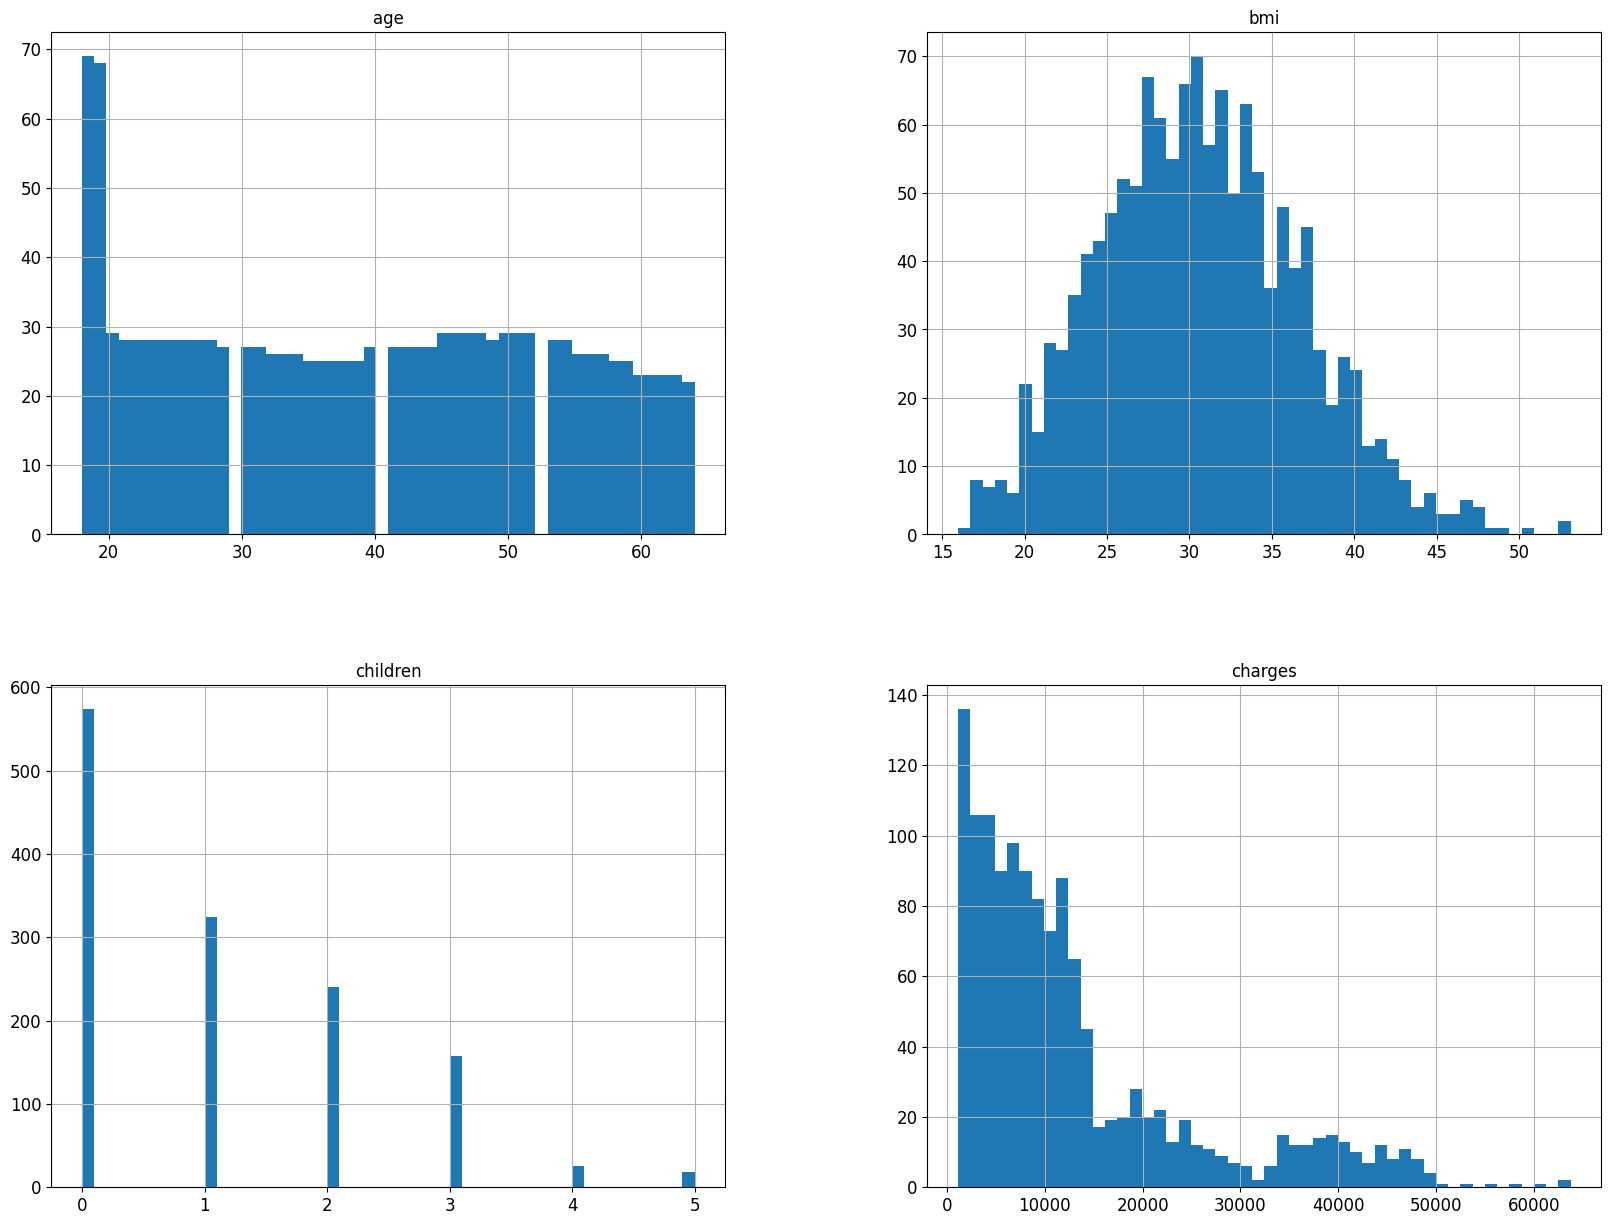

In [6]:
# histogram for each numberical attribute
%matplotlib inline

insurance.hist(bins=50, figsize=(20,15))
plt.show()

# Create a Test Set

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)

In [8]:
test_set.head()

,age,sex,bmi,children,smoker,region,charges
764,45,female,25.175,2,no,northeast,9095.06825
887,36,female,30.020,0,no,northwest,5272.17580
890,64,female,26.885,0,yes,northwest,29330.98315
1293,46,male,25.745,3,no,northwest,9301.89355
259,19,male,31.920,0,yes,northwest,33750.29180


In [9]:
# we want to ensure that the test set is representative of the various
# categories of ages in the whole dataset
# convert the age to a category attribute

insurance["age_cat"] = pd.cut(insurance["age"],
                              bins=[17, 25, 35, 45, 55, np.inf],
                              labels=[1,2,3,4,5])

In [10]:
insurance["age_cat"].value_counts()

age_cat
1    306
4    284
2    268
3    264
5    216
Name: count, dtype: int64

<Axes: >

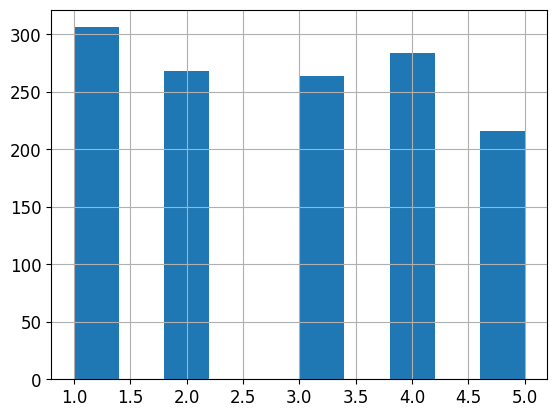

In [11]:
insurance["age_cat"].hist()

In [12]:
insurance[insurance["age_cat"].isna()]

,age,sex,bmi,children,smoker,region,charges,age_cat


In [13]:
# do stratified sampling based on the income category

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(insurance, insurance["age_cat"]):
    strat_train_set = insurance.loc[train_index]
    strat_test_set = insurance.loc[test_index]

In [14]:
strat_test_set["age_cat"].value_counts() / len(strat_test_set)

age_cat
1    0.227612
4    0.212687
2    0.201493
3    0.197761
5    0.160448
Name: count, dtype: float64

In [15]:
insurance["age_cat"].value_counts() / len(insurance)

age_cat
1    0.228700
4    0.212257
2    0.200299
3    0.197309
5    0.161435
Name: count, dtype: float64

In [16]:
# compare the income category
def income_cat_proportions(data):
    return data["age_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(insurance, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(insurance),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [17]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
age_cat,,,,,
1,0.228700,0.227612,0.231343,1.155985,-0.475563
2,0.200299,0.201493,0.235075,17.361885,0.595901
3,0.197309,0.197761,0.179104,-9.226594,0.228969
4,0.212257,0.212687,0.197761,-6.829409,0.202333
5,0.161435,0.160448,0.156716,-2.922886,-0.611526


In [18]:
# remove age_cat attribute so the data is back to its original form
for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_cat", axis=1, inplace=True)

# Exploratory Data Analysis

In [19]:
insurance = strat_train_set.copy()

Text(0.5, 1.0, 'Age vs Charges')

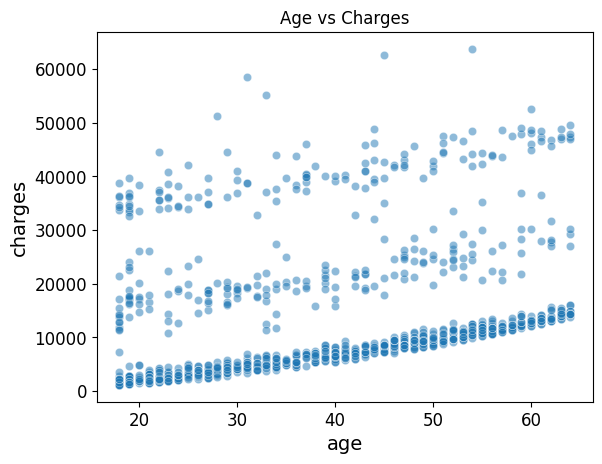

In [20]:
sns.scatterplot(data=insurance, x="age", y="charges", alpha=0.5)
plt.title("Age vs Charges")

Text(0.5, 1.0, 'Age vs Charges Colored by Smoker Status')

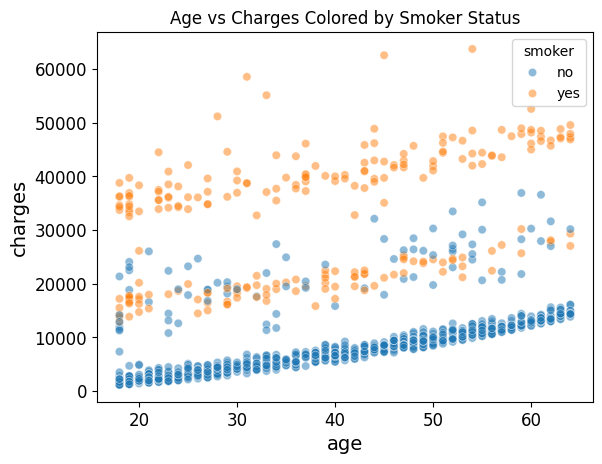

In [21]:
sns.scatterplot(data=insurance, x="age", y="charges", hue="smoker",
                alpha=0.5)
plt.title("Age vs Charges Colored by Smoker Status")

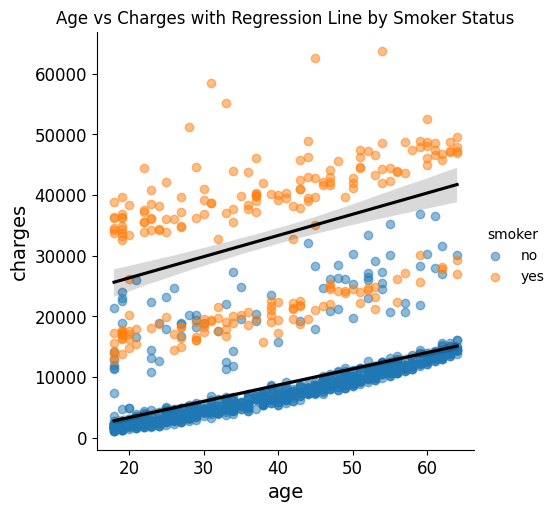

In [22]:
sns.lmplot(data=insurance, x="age", y="charges", hue="smoker",
            scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})
plt.title("Age vs Charges with Regression Line by Smoker Status")
plt.show()

* Being a smoker dramatically increases insurance charges, and the cost rises even more with age

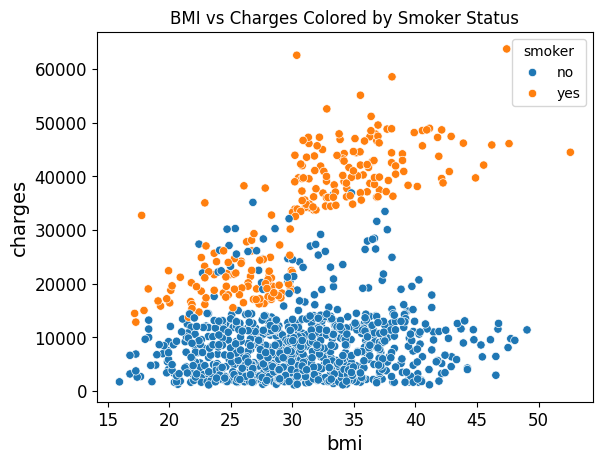

In [23]:
sns.scatterplot(data=insurance, x="bmi", y="charges",hue="smoker")
plt.title("BMI vs Charges Colored by Smoker Status")
plt.show()

* Here, we can see that while smoking status strongly correlates with higher insurance charges, there is evidence that BMI amplifies the cost burden among smokers, i.e. Lower BMI stay in the 20k - 30k zone and Higher BMI smokers stay in the 30k - 50k+ zone.

In [24]:
# compare mean charges by sex
insurance.groupby('sex')['charges'].mean()

sex
female    12924.272486
male      14505.166293
Name: charges, dtype: float64

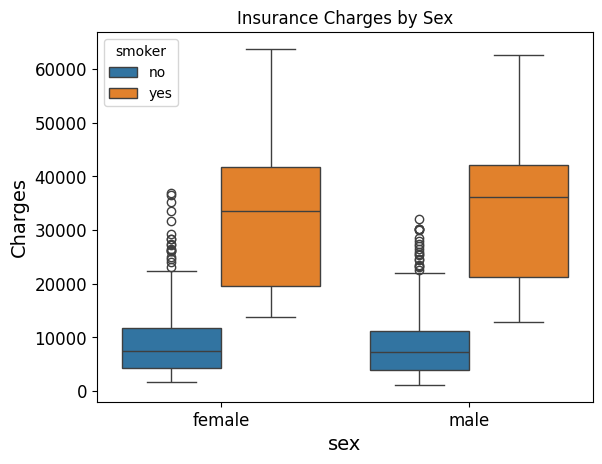

In [25]:
# Does sex affect insurance charges paid?
sns.boxplot(x="sex", y="charges",hue='smoker', data=insurance)
plt.title("Insurance Charges by Sex")
plt.ylabel("Charges")
plt.show()

* Non-smokers generally have lower charges, though some outliers exist - especially among females
* Female non-smokers have charges peaking just before 40k, while male non-smokers peak around 30k
* Among smokers, male mean/median charge is higher, but female smokers show a wider range
* Smoking remains the key factor influencing higher insurance costs accross both genders

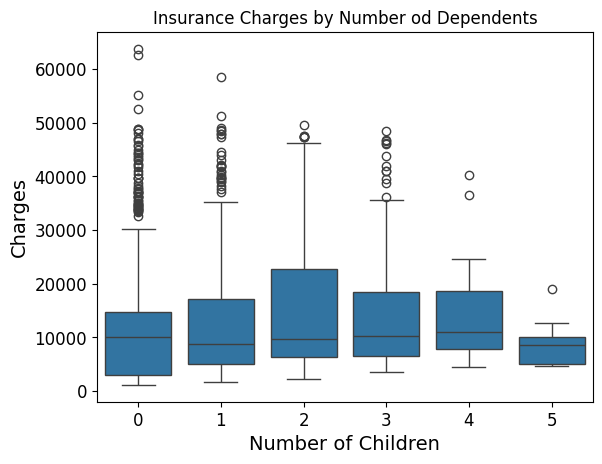

In [26]:
# Does number of children affect the charges paid?
sns.boxplot(x="children", y="charges", data=insurance)
plt.title("Insurance Charges by Number od Dependents")
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()

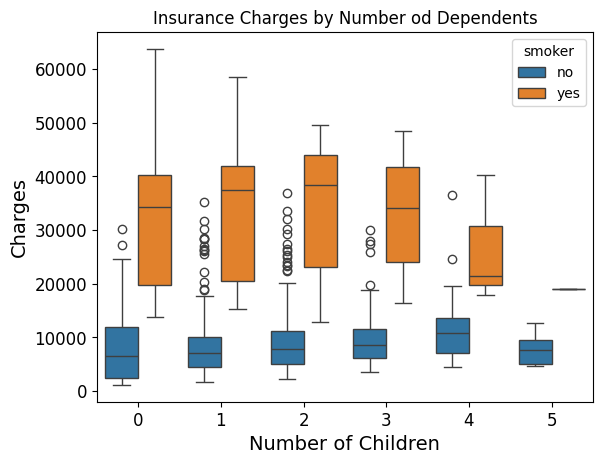

In [27]:
sns.boxplot(x="children", y="charges",hue="smoker", data=insurance)
plt.title("Insurance Charges by Number od Dependents")
plt.xlabel("Number of Children")
plt.ylabel("Charges")
plt.show()

* While smoking is still a huge factor, it's safe to say here that, the higher the number of children, the lower the charges, for both smokers and non-smokers.

C:\Users\USER\AppData\Local\Temp\ipykernel_8672\1810978008.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="region", y="charges", estimator="mean",


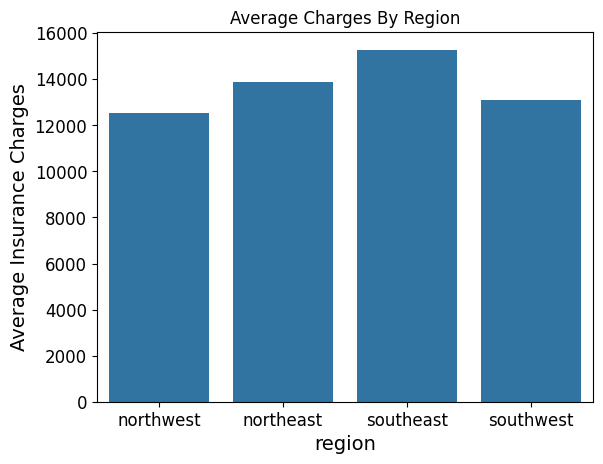

In [28]:
# By region
sns.barplot(x="region", y="charges", estimator="mean",
            data=insurance, ci=None)
plt.title("Average Charges By Region")
plt.ylabel("Average Insurance Charges")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_8672\2318888068.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="region", y="charges", estimator="mean",


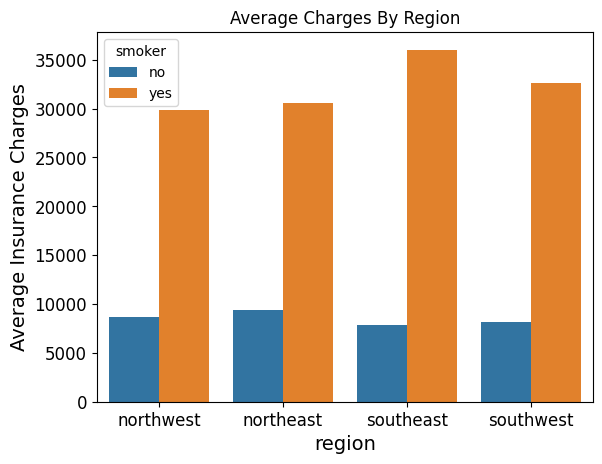

In [29]:
# By region
sns.barplot(x="region", y="charges", estimator="mean",
            data=insurance, ci=None, hue="smoker")
plt.title("Average Charges By Region")
plt.ylabel("Average Insurance Charges")
plt.show()

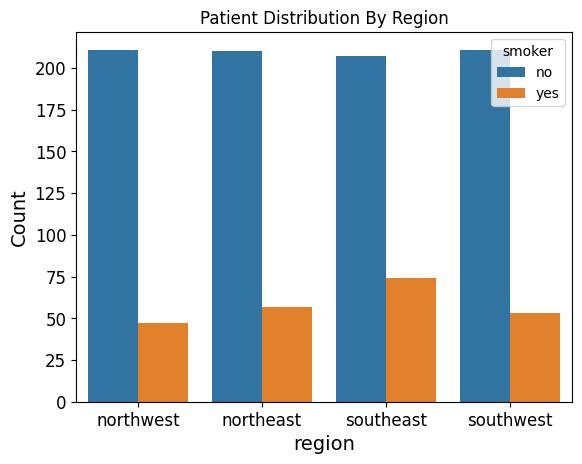

In [30]:
# see sample distribution accross each region
sns.countplot(x="region", data=insurance, hue="smoker")
plt.title("Patient Distribution By Region")
plt.ylabel("Count")
plt.show()

* While non-smokers are majority in the data, we can see that smoking is more prevalet in the Southeast followed by the Northease, the Southwest and then, the Nortwest.
* For the Average Insurance Charges paid, Smokers in the Southeast pay the highest, followed by Southwest, Northeast and Northwest
* While Non-smokers in the Northeast pay the highest average charge, followed by the Northwest, Southwest and Southeast.

# Let's then check for Correlations

In [31]:
corr_matrix = insurance.select_dtypes(include=[np.number]).corr()

In [32]:
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.285159
bmi         0.233447
children    0.052562
Name: charges, dtype: float64

array([[<Axes: xlabel='charges', ylabel='charges'>,
        <Axes: xlabel='age', ylabel='charges'>,
        <Axes: xlabel='bmi', ylabel='charges'>,
        <Axes: xlabel='children', ylabel='charges'>],
       [<Axes: xlabel='charges', ylabel='age'>,
        <Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>,
        <Axes: xlabel='children', ylabel='age'>],
       [<Axes: xlabel='charges', ylabel='bmi'>,
        <Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>,
        <Axes: xlabel='children', ylabel='bmi'>],
       [<Axes: xlabel='charges', ylabel='children'>,
        <Axes: xlabel='age', ylabel='children'>,
        <Axes: xlabel='bmi', ylabel='children'>,
        <Axes: xlabel='children', ylabel='children'>]], dtype=object)

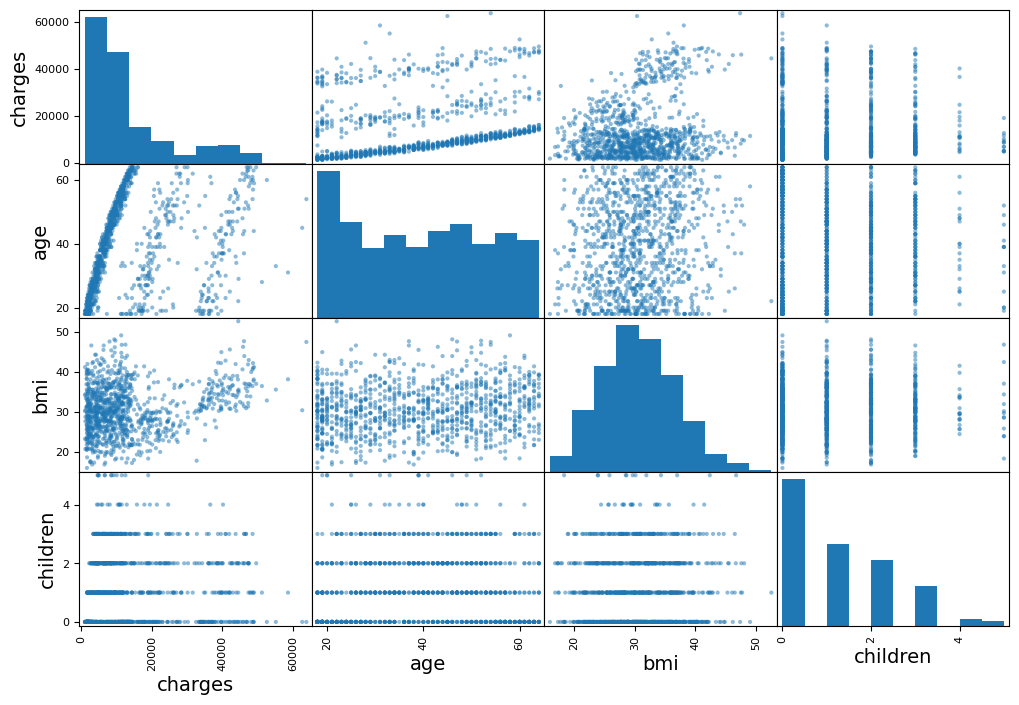

In [33]:
# plot scatter matrix
from pandas.plotting import scatter_matrix

attributes = ["charges", "age", "bmi", "children"]
scatter_matrix(insurance[attributes], figsize=(12,8))

# Experimenting with Attribute Combinations

In [34]:
insurance["bmi_smoker"] = insurance["bmi"] * insurance["smoker"].map({'yes': 1, 'no': 0})
insurance['age_bmi'] = insurance['age'] * insurance['bmi']
insurance["children_smoker"] = insurance["children"] * insurance["smoker"].map({'yes': 1, 'no': 0})
insurance["age_smoker"] = insurance["age"] * insurance["smoker"].map({'yes': 1, 'no': 0})

In [35]:
corr_matrix = insurance.select_dtypes(include=[np.number]).corr()
corr_matrix["charges"].sort_values(ascending=False)

charges            1.000000
bmi_smoker         0.851100
age_smoker         0.801676
children_smoker    0.515910
age_bmi            0.335138
age                0.285159
bmi                0.233447
children           0.052562
Name: charges, dtype: float64

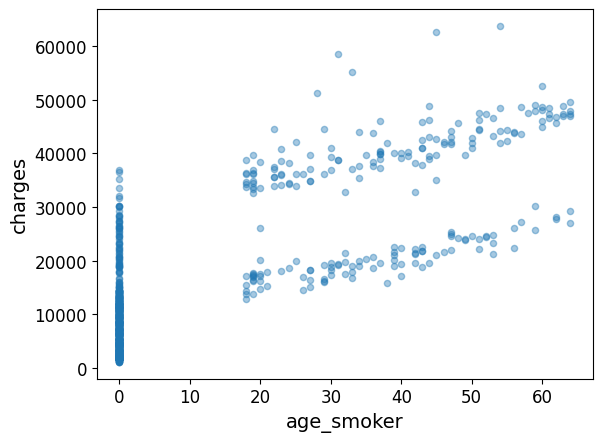

In [36]:
insurance.plot(kind="scatter", x="age_smoker", y="charges",
               alpha=0.4)
plt.show()

In [37]:
insurance.describe()

,age,bmi,children,charges,bmi_smoker,age_bmi,children_smoker,age_smoker
count,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000,1070.000000
mean,39.193458,30.649168,1.098131,13729.494098,6.696986,1212.317187,0.232710,8.207477
std,14.058176,6.127560,1.194271,12524.586937,13.118181,528.947922,0.687354,16.941984
min,18.000000,15.960000,0.000000,1121.873900,0.000000,287.280000,0.000000,0.000000
25%,26.000000,26.315000,0.000000,4803.718837,0.000000,760.430000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9575.442100,0.000000,1146.890000,0.000000,0.000000
75%,51.000000,34.800000,2.000000,17442.179450,0.000000,1587.715000,0.000000,0.000000
max,64.000000,52.580000,5.000000,63770.428010,52.580000,2845.480000,5.000000,64.000000


# Prepare the Data for Machine Learning Algorithms

In [38]:
insurance = strat_train_set.drop("charges", axis=1)
insurance_labels = strat_train_set["charges"].copy()

In [39]:
# preprocess the categorical variables

insurance_cat = insurance.select_dtypes(include=["object"])
insurance_cat.head(10)

,sex,smoker,region
486,female,no,northwest
172,male,no,northeast
560,female,no,northwest
376,female,yes,northeast
1036,male,yes,southeast
1254,female,no,southeast
255,female,no,northeast
465,female,yes,southeast
123,male,yes,northeast
779,male,no,northwest


In [40]:
# use onehot encoder to encode
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse_output=False)
insurance_cat_1hot = cat_encoder.fit_transform(insurance_cat)
insurance_cat_1hot

array([[1., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [41]:
cat_encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

# Custom Transformers

In [42]:
# create a custom transformer to add extra attributes
from sklearn.base import BaseEstimator, TransformerMixin

# define class and __init__() method
class ExtraAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,
                 add_bmi_smoker=True,
                 add_age_bmi=True,
                 add_children_smoker=True,
                 add_age_smoker=True):
        self.add_bmi_smoker = add_bmi_smoker
        self.add_age_bmi = add_age_bmi
        self.add_children_smoker = add_children_smoker
        self.add_age_smoker = add_age_smoker

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Add BMI-Smoker
        if 'bmi' in X.columns and 'smoker' in X.columns:
            X['bmi_smoker'] = X["bmi"] * X["smoker"].map({'yes': 1, 'no': 0})

        # Add Age-BMI
        if 'age' in X.columns and 'bmi' in X.columns:
            X['age_bmi'] = X["age"] * X["bmi"]

        # Add Children_Smoker
        if 'bmi' in X.columns and 'smoker' in X.columns:
            X['children_smoker'] = X["children"] * X["smoker"].map({'yes': 1, 'no': 0})

        # Add Age_Smoker
        if 'bmi' in X.columns and 'smoker' in X.columns:
            X['age_smoker'] = X["age"] * X["smoker"].map({'yes': 1, 'no': 0})

        return X
    
attr_adder = ExtraAttributesAdder(add_children_smoker=False)
insurance_extra_attribs = attr_adder.transform(insurance)

In [43]:
insurance_extra_attribs = pd.DataFrame(
    insurance_extra_attribs,
    columns=list(insurance.columns)+["bmi_smoker", "age_bmi", "age_smoker"],
    index=insurance.index)
insurance_extra_attribs.head()

,age,sex,bmi,children,smoker,region,bmi_smoker,age_bmi,age_smoker
486,54,female,21.47,3,no,northwest,0.00,1159.38,0
172,18,male,15.96,0,no,northeast,0.00,287.28,0
560,46,female,19.95,2,no,northwest,0.00,917.70,0
376,39,female,24.89,3,yes,northeast,24.89,970.71,39
1036,22,male,37.07,2,yes,southeast,37.07,815.54,22


In [61]:
# based on the results from grid search cv feature importance, I want to try dropping some models

class DropLowImportanceFeatures(BaseEstimator, TransformerMixin):
    def __init__ (self, features_to_drop):
        self.features_to_drop = features_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, np.ndarray):
            raise ValueError("Input must be a DataFrame, not a NumPy array.")
        return X.drop(self.features_to_drop, axis=1)
    
attr_dropper = DropLowImportanceFeatures(features_to_drop=['children', 'region', 'gender'])

In [64]:
def transform(self, X):
    if not isinstance(X, pd.DataFrame):
        raise TypeError("FeatureDropper expects a DataFrame.")
    
    print("Incoming columns:", X.columns.tolist())
    print("Columns to drop:", self.columns_to_drop)

    missing = [col for col in self.columns_to_drop if col not in X.columns]
    if missing:
        raise KeyError(f"The following columns are not in the dataframe: {missing}")
    return X.drop(columns=self.columns_to_drop).copy()

# Transformation Pipelines
Build a pipeline for preprocessing the numerical attributes

In [45]:
insurance_num = insurance.select_dtypes(include=[np.number])

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

insurance_num_tr = num_pipeline.fit_transform(insurance_num)

In [47]:
insurance_num_tr.shape

(1070, 3)

In [48]:
insurance_num_tr

array([[ 1.05372599, -1.49871419,  1.59323874],
       [-1.50825881, -2.39835073, -0.919929  ],
       [ 0.48439604, -1.74688979,  0.75551616],
       ...,
       [-0.08493392, -2.25875196,  0.75551616],
       [ 1.5518897 ,  2.17983597, -0.919929  ],
       [ 1.19605848, -0.33539107, -0.919929  ]])

In [49]:
insurance.head()

,age,sex,bmi,children,smoker,region
486,54,female,21.47,3,no,northwest
172,18,male,15.96,0,no,northeast
560,46,female,19.95,2,no,northwest
376,39,female,24.89,3,yes,northeast
1036,22,male,37.07,2,yes,southeast


In [62]:
from sklearn.compose import ColumnTransformer

num_attribs = list(insurance_num)+["bmi_smoker", "age_bmi", "age_smoker"]
cat_attribs = list(insurance_cat)

full_pipeline = Pipeline([
    ('attribs_remover', DropLowImportanceFeatures(features_to_drop=['children', 'sex', 'region'])),
    ('attribs_adder', ExtraAttributesAdder()),
    ('preprocessor', ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
]))
])


insurance_prepared = full_pipeline.fit_transform(insurance)

KeyError: 'children'

In [55]:
insurance_prepared

array([[ 1.05372599, -1.49871419,  1.59323874, ...,  1.        ,
         0.        ,  0.        ],
       [-1.50825881, -2.39835073, -0.919929  , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.48439604, -1.74688979,  0.75551616, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.08493392, -2.25875196,  0.75551616, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.5518897 ,  2.17983597, -0.919929  , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.19605848, -0.33539107, -0.919929  , ...,  0.        ,
         0.        ,  0.        ]])

In [56]:
insurance_prepared.shape

(1070, 14)

# Select and Train a Model

## Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(insurance_prepared, insurance_labels)

LinearRegression()

In [ ]:
# try the full preprocessing pipeline on a few training instances
some_data = insurance.iloc[:5]
some_labels = insurance_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions: ", lin_reg.predict(some_data_prepared))

Predictions:  [13372.58280921  2590.53237683 10715.24244214 26486.62635291
 36280.59304345]


compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

Labels: [12475.3513, 1694.7964, 9193.8385, 21659.9301, 37484.4493]


In [ ]:
from sklearn.metrics import mean_squared_error

insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(4890.7498405176475)

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(insurance_labels, insurance_predictions)
lin_mae

np.float64(2982.088406424078)

In [ ]:
# try another model
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(insurance_prepared, insurance_labels)

DecisionTreeRegressor()

In [ ]:
insurance_predictions = tree_reg.predict(insurance_prepared)
tree_mse = mean_squared_error(insurance_labels, insurance_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(494.20598375812835)

From the earlier model used - Linear regression, the rmse was about 6093, which although is quite okay, is still high. This could have been a sign of overfitting, meaning the model was too simple to properly capture the relationships. 

So, a more complex model - Decision Tree Regressor was used and to further confirm the overfitting, the rmse was reduced to 494.21. To be certain, we'll do further validations

# Better Evaluation using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [6929.19666433 6109.12748322 5681.81761758 6247.40983138 5413.33205863
 7711.850561   6678.54456614 6471.7025538  7044.78054501 6446.66074582]
Mean: 6473.442262692171
Standard deviation: 635.9953611418297


When tested across multiple folds, the performance dropped to the range of the linear regression trained earlier. This clearly shows that the model was definitely overfittingon the training set and is not generalizing well.

In [ ]:
# try the same for the linear regression model
lin_scores = cross_val_score(lin_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [4313.83036222 4399.62106685 4716.4519602  4720.08193671 4625.92970121
 5915.2164414  4926.37387536 5603.00628693 4741.50018031 5288.38448981]
Mean: 4925.039630098851
Standard deviation: 492.99305875025306


* linear regression performs better

In [ ]:
# try another model - Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(insurance_prepared, insurance_labels)

RandomForestRegressor(random_state=42)

In [ ]:
insurance_predictions = forest_reg.predict(insurance_prepared)
forest_mse = mean_squared_error(insurance_labels, insurance_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(1854.0940380739619)

In [ ]:
forest_scores = cross_val_score(forest_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [3993.37028077 4297.13244681 4398.97324937 4181.63182749 4164.36757832
 5976.2450578  4996.39612386 5452.59317783 4448.93893701 5285.92984448]
Mean: 4719.557852374603
Standard deviation: 631.9352442087737


* After using the Random forest regressor,, we can see that the RSME for the train set is much lower than that of the two other models trained earlier, showing that this model fits the training data very well
* It can also be notised that RSME for validation sets is much higher than the one for training, which suggests overfitting. But, it's still much lower than the other models trained earlier, showig that this model is much better and could just need some little bit of fine-tuning.

## Try More models

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(insurance_prepared, insurance_labels)
housing_predictions = svm_reg.predict(insurance_prepared)
svm_mse = mean_squared_error(insurance_labels, insurance_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(1854.0940380739619)

In [ ]:
# from sklearn.svm import SVR

# svm_reg = SVR(kernel="rbf")
# svm_reg.fit(insurance_prepared, insurance_labels)
# housing_predictions = svm_reg.predict(insurance_prepared)
# svm_mse = mean_squared_error(insurance_labels, insurance_predictions)
# svm_rmse = np.sqrt(svm_mse)
# svm_rmse

In [ ]:
svm_scores = cross_val_score(svm_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=10)
svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [10301.05176095  9308.96501283 14324.1495439  12795.35468135
 13384.31330598 13051.18905252 12169.1591797  12732.27476138
 10785.79450767 11145.35483478]
Mean: 11999.760664106887
Standard deviation: 1481.6622511012495


In [ ]:
# use Ridge Regression model (L2 Regularization)

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(insurance_prepared, insurance_labels)
housing_predictions = ridge_reg.predict(insurance_prepared)
ridge_mse = mean_squared_error(insurance_labels, insurance_predictions)
ridge_rmse = np.sqrt(ridge_mse)
svm_rmse


np.float64(1854.0940380739619)

In [ ]:
ridge_scores = cross_val_score(ridge_reg, insurance_prepared, insurance_labels,
                         scoring="neg_mean_squared_error", cv=10)
ridge_rmse_scores = np.sqrt(-ridge_scores)
display_scores(ridge_rmse_scores)

Scores: [4312.09347879 4400.11829965 4716.19737076 4717.36891063 4627.9130006
 5912.80693095 4925.47356767 5605.48281807 4742.64471689 5288.99099927]
Mean: 4924.909009327496
Standard deviation: 493.02003330319315


In [ ]:
# use XGBoost

import xgboost as xgb
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(insurance_prepared, insurance_labels)
housing_predictions = xgb_reg.predict(insurance_prepared)
xgb_mse = mean_squared_error(insurance_labels, insurance_predictions)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse

np.float64(1854.0940380739619)

# Fine-Tune Model
* I will be going ahead with Random Forest Regressor

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    # try 12 (3*4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2*3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(insurance_prepared, insurance_labels)

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [ ]:
# evaluation scores
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5440.078359478142 {'max_features': 2, 'n_estimators': 3}
4895.099997082052 {'max_features': 2, 'n_estimators': 10}
4732.113970195392 {'max_features': 2, 'n_estimators': 30}
5254.594177319251 {'max_features': 4, 'n_estimators': 3}
4786.899533539759 {'max_features': 4, 'n_estimators': 10}
4712.55251360965 {'max_features': 4, 'n_estimators': 30}
5367.74628943466 {'max_features': 6, 'n_estimators': 3}
4845.306762443835 {'max_features': 6, 'n_estimators': 10}
4688.149334877766 {'max_features': 6, 'n_estimators': 30}
5381.2235320071 {'max_features': 8, 'n_estimators': 3}
4877.518625696124 {'max_features': 8, 'n_estimators': 10}
4785.366870449671 {'max_features': 8, 'n_estimators': 30}
5488.203840299279 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
4934.712417923812 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
5602.579942565855 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
4985.41799419362 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
533

In [ ]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013774,0.003515,0.001996,0.000630,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-2.294372e+07,-3.192877e+07,...,-2.959445e+07,3.767064e+06,16,-7.683775e+06,-7.937977e+06,-7.870979e+06,-8.040526e+06,-8.225603e+06,-7.951772e+06,179666.889992
1,0.020733,0.000923,0.001627,0.000513,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-1.942552e+07,-2.230572e+07,...,-2.396200e+07,3.244807e+06,8,-4.506421e+06,-4.824757e+06,-4.550968e+06,-4.104070e+06,-4.322740e+06,-4.461791e+06,240411.426087
2,0.060804,0.001207,0.002699,0.000481,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-1.851332e+07,-1.956147e+07,...,-2.239290e+07,3.024130e+06,3,-3.708834e+06,-3.787290e+06,-3.622702e+06,-3.463012e+06,-3.417566e+06,-3.599881e+06,141057.340530
3,0.009311,0.001384,0.001148,0.000198,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-2.420189e+07,-2.454508e+07,...,-2.761076e+07,3.054665e+06,12,-7.452291e+06,-8.135495e+06,-7.001735e+06,-7.273957e+06,-7.538764e+06,-7.480448e+06,375522.277286
4,0.025594,0.000966,0.001885,0.000429,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-1.852791e+07,-1.849329e+07,...,-2.291441e+07,3.700574e+06,5,-4.572308e+06,-4.535303e+06,-4.197092e+06,-4.344714e+06,-4.311512e+06,-4.392186e+06,141244.429710
5,0.076081,0.005192,0.003270,0.000612,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-1.845588e+07,-1.766494e+07,...,-2.220815e+07,3.424292e+06,2,-3.767933e+06,-3.764343e+06,-3.419271e+06,-3.416062e+06,-3.331351e+06,-3.539792e+06,187485.133217
6,0.009304,0.000569,0.001355,0.000410,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-2.286647e+07,-2.500717e+07,...,-2.881270e+07,4.275519e+06,14,-8.294640e+06,-6.765740e+06,-7.190223e+06,-6.705117e+06,-7.547218e+06,-7.300588e+06,583402.700824
7,0.029405,0.000902,0.002150,0.000614,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-1.777157e+07,-2.114976e+07,...,-2.347700e+07,3.541302e+06,6,-4.715592e+06,-4.395068e+06,-4.344513e+06,-4.103480e+06,-4.254477e+06,-4.362626e+06,202394.742910
8,0.084898,0.002806,0.003277,0.000597,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-1.679073e+07,-1.899998e+07,...,-2.197874e+07,3.485166e+06,1,-3.673836e+06,-3.633697e+06,-3.541369e+06,-3.375114e+06,-3.457055e+06,-3.536214e+06,110171.302268
9,0.011299,0.001056,0.001101,0.000074,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-2.037079e+07,-2.580915e+07,...,-2.895757e+07,5.718230e+06,15,-8.513329e+06,-7.818710e+06,-7.076634e+06,-5.820518e+06,-7.299612e+06,-7.305761e+06,892168.187805


## Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8)
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(insurance_prepared, insurance_labels)

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002269F3D3FE0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002269F376B70>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

4691.379957106989 {'max_features': 7, 'n_estimators': 180}
4844.245443668101 {'max_features': 5, 'n_estimators': 15}
4627.481079691446 {'max_features': 3, 'n_estimators': 72}
4745.426965835676 {'max_features': 5, 'n_estimators': 21}
4684.753075896588 {'max_features': 7, 'n_estimators': 122}
4622.343874596855 {'max_features': 3, 'n_estimators': 75}
4616.139422054278 {'max_features': 3, 'n_estimators': 88}
4643.7292326443885 {'max_features': 5, 'n_estimators': 100}
4644.716912100416 {'max_features': 3, 'n_estimators': 150}
5757.6373074077865 {'max_features': 5, 'n_estimators': 2}


# Analyze the Best Models and Their Errors

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.06955351, 0.06815865, 0.01708476, 0.40820607, 0.08400527,
       0.12879423, 0.00227389, 0.0025205 , 0.10890901, 0.09760987,
       0.0045637 , 0.00276143, 0.00308081, 0.00247828])

In [ ]:
# show the scores next to their attribute names
# extra_attribs = ["bmi_smoker", "age_bmi", "children_smoker", "age_smoker"]
cat_encoder = full_pipeline.named_steps['preprocessor'].named_transformers_["cat"]
cat_one_hot_attribs = []
for categories in cat_encoder.categories_:
    cat_one_hot_attribs += list(categories)
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.40820606644090957), 'bmi_smoker'),
 (np.float64(0.128794227169939), 'age_smoker'),
 (np.float64(0.10890901115669022), 'no'),
 (np.float64(0.09760987447286557), 'yes'),
 (np.float64(0.08400527014422622), 'age_bmi'),
 (np.float64(0.06955351034613436), 'age'),
 (np.float64(0.06815865497657249), 'bmi'),
 (np.float64(0.017084764025284346), 'children'),
 (np.float64(0.004563700631552365), 'northeast'),
 (np.float64(0.00308081051794137), 'southeast'),
 (np.float64(0.0027614334124983018), 'northwest'),
 (np.float64(0.0025205028996160696), 'male'),
 (np.float64(0.002478282066866526), 'southwest'),
 (np.float64(0.002273891738903735), 'female')]